In [63]:
import numpy as np
import json
import torch
import torch.nn as nn
from networks import SCLIPNN
import clip
from PIL import Image
from sentence_transformers import SentenceTransformer
import torchvision.transforms.functional as fn
import pandas as pd
import yaml
import os

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
directory = cfg["dataset"]["dirname"]
image_directory = cfg["dataset"]["images"]
languages = cfg["languages"]

In [65]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2') #distiluse-base-multilingual-cased-v1') #
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [66]:
def reshape(im):
    print("This is size of original image:",im.size, "\n")
    width, height = im.size
    # print("W: {} and H: {}".format(width, height))
    if width > 1000 or height > 1000:
        scale = 3
    elif width > 500 or height > 500:
        scale = 2
    else:
        scale = 1    
    new_width = int(width / scale)
    new_height = int(height / scale)
    #image = preprocess(im)
    image = fn.resize(im, size=[new_width])
    print("This is size of resized image:",image.size, "\n")
    return image

In [67]:
def get_logits(image_features, text_features):
    # normalized features
    if text_features.dtype == torch.int64:
        text_features = text_features.type(torch.FloatTensor)
    image_features = (image_features / image_features.norm(dim=-1, keepdim=True)).to(device)
    text_features = (text_features / text_features.norm(dim=-1, keepdim=True)).to(device)

    # cosine similarity as logits
    logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
    logit_scale = logit_scale.exp().to(device)
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()

    # shape = [global_batch_size, global_batch_size]
    return logits_per_image, logits_per_text  

In [68]:
def sbert_to_clip(sbert_features, name_model):
    splitted_name = name_model.split("_")
    hidden_size = int(splitted_name[2])
    input_size = sbert_features.shape[1]
    PATH = os.path.join("models",name_model)
    model = SCLIPNN(input_size,hidden_size)
    model.load_state_dict(torch.load(PATH))
    model.eval()
    output = model(sbert_features)
    return output

In [69]:
def get_image(directory, image_id):
    image = Image.open(directory + image_id)
    return image

In [70]:
def reciprocal_rank(probs, value):
    N = len(probs)
    copy_probs = list(probs.copy())
    for i in range(N):
        max_value = max(copy_probs)
        if max_value == value:
            return 1/(i + 1)
        else:
            copy_probs.remove(max_value)
    return 1/N

In [72]:
def get_MRR(model, directory, languages, sbert_model, captions, images_features, clip_features):
    sbert_lang_performance = []
    clip_lang_performance = []
    sbert_lang_errors = []
    clip_lang_errors = []
    sbert_lang_mrr = []
    clip_lang_mrr = []
    vetoed = []
    for lang, code in languages.items():
        print("Processing captions in "+ lang +"...")
        f_json =  open(directory + code + "_pairs.json",mode='r',encoding='utf-8')
        pairs_data = json.load(f_json)
        images = []
        captions = []
        for pair in pairs_data:
            images.append(pair["image_id"])
            captions.append(pair["caption"])

        # Model to use
        name_of_model = "coco_NN_900_e300_s400000.pt"

        with torch.no_grad():
            try:
                torch_features = torch.from_numpy(sbert_model.encode(captions))
                sbert_features = sbert_to_clip(torch_features,name_of_model).type(torch.float16)
                tokenized_features = clip.tokenize(captions).to(device)
                clip_features = clip_model.encode_text(tokenized_features)
            except:
                print("Not able to tokenize in {}. Skipping language {}".format(lang, code))
                vetoed.append(lang)
                continue

            sbert_performance = []
            clip_performance = []
            sbert_errors = 0
            clip_errors = 0
            sbert_rr = 0
            clip_rr = 0
            counter = 0

            for image_id in images:
                # Get the encoding of the image
                im = get_image(image_directory, image_id)
                image = preprocess(im).unsqueeze(0).to(device)
                image_features = clip_model.encode_image(image)

                # Get the probabilities for SBERT and CLIP
                logits_image_sbert, logits_text_sbert = get_logits(image_features, sbert_features)
                logits_image_clip, logits_text_clip = get_logits(image_features, clip_features)
                probs_clip = logits_image_clip.softmax(dim=-1).cpu().numpy()
                probs_sbert = logits_image_sbert.softmax(dim=-1).cpu().numpy()

                # Append the probs to array            
                ps = probs_sbert[0][counter]
                sbert_rr += reciprocal_rank(probs_sbert[0],ps)
                sbert_performance.append(ps)
                if ps < max(probs_sbert[0]):
                    sbert_errors += 1
                pc = probs_clip[0][counter]
                clip_rr += reciprocal_rank(probs_clip[0],pc)
                clip_performance.append(pc)
                if pc < max(probs_clip[0]):
                    clip_errors += 1
                counter += 1

        # print("Images processed: {}".format(counter))
        # print("Classifications errors: SBERT --> {} ; CLIP --> {}".format(sbert_errors,clip_errors))
        sbert_lang_performance.append(round(sum(sbert_performance)/counter,6))
        clip_lang_performance.append(round(sum(clip_performance)/counter,6))
        sbert_lang_mrr.append(round(sbert_rr/counter,4))
        clip_lang_mrr.append(round(clip_rr/counter,4))
        sbert_lang_errors.append(sbert_errors)
        clip_lang_errors.append(clip_errors)
    print("Done")
    print("Forbidden Languages: {}".format(vetoed))

    return sbert_lang_performance, clip_lang_performance, sbert_lang_mrr, clip_lang_mrr, sbert_lang_errors, clip_lang_errors

Processing captions in English...
Processing captions in Spanish...
Processing captions in Italian...
Processing captions in German...
Processing captions in French...
Done
Forbidden Languages: []


In [73]:
r = dict(languages)
for k in vetoed:
    if k in r:
        del r[k]
languages = r

In [74]:
print("Languages: {}".format(languages))
print("SBERT performance: {}".format(sbert_lang_performance))
print("CLIP performance: {}".format(clip_lang_performance))

Languages: {'English': 'en', 'Spanish': 'es', 'Italian': 'it', 'German': 'de', 'French': 'fr'}
SBERT performance: [0.063924, 0.057844, 0.058054, 0.059676, 0.062021]
CLIP performance: [0.091794, 0.039343, 0.034438, 0.033382, 0.042905]


In [75]:
results = pd.DataFrame({"SBERT":sbert_lang_performance, "CLIP": clip_lang_performance,
                        "error SBERT":sbert_lang_errors, "error CLIP":clip_lang_errors,
                       "MRR sbert":sbert_lang_mrr, "MRR clip": clip_lang_mrr}, 
                       index=languages)
results

,SBERT,CLIP,error SBERT,error CLIP,MRR sbert,MRR clip
English,0.063924,0.091794,25,18,0.7825,0.8511
Spanish,0.057844,0.039343,30,38,0.7374,0.6481
Italian,0.058054,0.034438,33,45,0.7144,0.5564
German,0.059676,0.033382,27,44,0.7567,0.5554
French,0.062021,0.042905,29,33,0.7523,0.6816


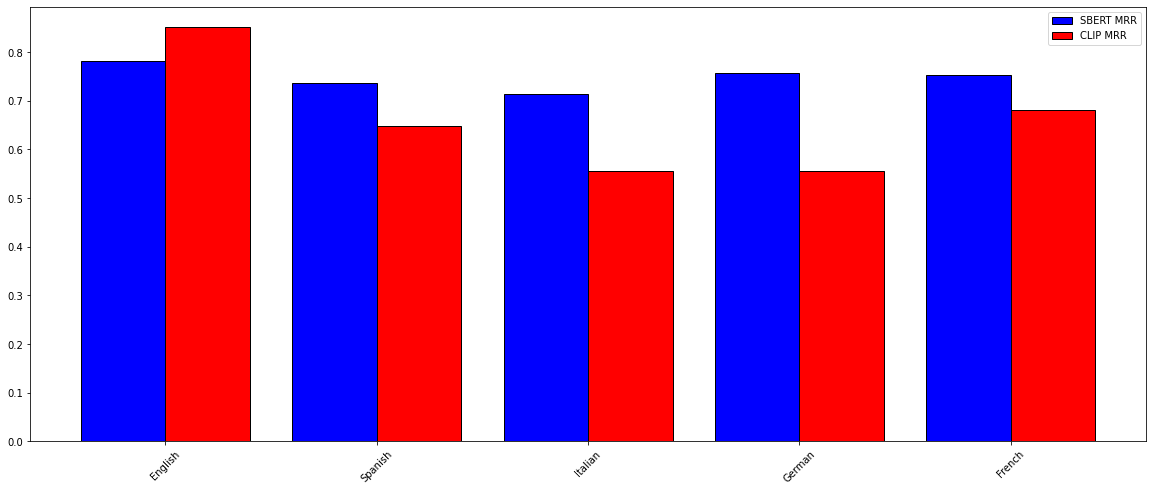

In [76]:
import matplotlib.pyplot as plt
X_axis = np.arange(len(languages.keys()))
figure_name = plt.figure(figsize=(20, 8))
plt.bar(X_axis-0.2, sbert_lang_mrr, 0.4, color = 'blue', edgecolor = 'black', capsize=7, label='SBERT MRR')
plt.bar(X_axis+0.2, clip_lang_mrr, 0.4, color = 'red', edgecolor = 'black', capsize=7, label='CLIP MRR')
plt.xticks(rotation = 45)
plt.xticks(X_axis, languages.keys())
plt.legend()
plt.show()